In [26]:
playback=True

In [8]:
import cv2
from pprint import pprint

def is_fourcc_available(codec):
    try:
        fourcc = cv2.VideoWriter_fourcc(*codec)
        temp_video = cv2.VideoWriter('temp.mkv', fourcc, 30, (640, 480), isColor=True)
        return temp_video.isOpened()
    except:
        return False

def enumerate_fourcc_codecs():
    codecs_to_test = ["XVID","RGBA","MJPG","IYUV","mp4v","b48r"]
    available_codecs = []
    for codec in codecs_to_test:
        available_codecs.append((codec, is_fourcc_available(codec)))
    return available_codecs

codecs = enumerate_fourcc_codecs()
print("Available FourCC codecs:")
pprint(codecs)

Available FourCC codecs:
[('XVID', True),
 ('RGBA', True),
 ('MJPG', True),
 ('IYUV', True),
 ('mp4v', True),
 ('b48r', True)]


In [27]:
#getting the raw data and running the model
import numpy as np
import cv2
import msgpack as msgp
import msgpack_numpy as mpn
import glob
import os
import matplotlib.pyplot as plt
import sympy as sp
import time
import numpy as np
import mediapipe as mp
import datetime
import matplotlib.pyplot as plt
import sympy as sp
from scipy.signal import savgol_filter

# Setting the parameters of the stream
h=480 #720 
w=640 #1280
fps=30
windowscale=0.6

def midpoint(p1,p2):
    '''
    calculates the midpoint of two points
    p1,p2 : lists/like representing the points
    returns : midpoint
    '''
    mid=[]
    for i in range(len(p1)):
        mid.append((p1[i]+p2[i])/2)
    return mid

# Initializing the model to locate the landmarks
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Initializing the landmark lists
LS, LE, LW, RS, RE, RW, TR = [], [], [], [], [], [], []
RI,LI=[],[]
 
# Initializing the drawing utils for drawing the facial landmarks on image
mp_drawing = mp.solutions.drawing_utils
 
# Initializing current time and precious time for calculating the FPS
previousTime = 0
currentTime = 0

frames=0

pth = r"C:\Users\arpan\OneDrive\Documents\internship\rec_program\savdir\Session 17-06-23_10-19-20_7391";

lst = os.listdir(pth)
vid_name = lst[-1]

targetPattern = f"{pth}\\DEPTH*"
campth = glob.glob(targetPattern)

targetPattern_param = f"{pth}\\PARAM*"
ppth = glob.glob(targetPattern_param)

targetPattern_colour = f"{pth}\\COLOUR*"
cpth = glob.glob(targetPattern_colour)

# campth.pop(0)
# cpth.pop(0)

print(campth)
print(cpth)
print(ppth)

img = []
c=0
for i in cpth:
    print(i)
    col_file = open(i, "rb")
    unpacker = None
    unpacker = msgp.Unpacker(col_file, object_hook=mpn.decode)
    for unpacked in unpacker:
        #_tmp = np.array(unpacked)
        #print(_tmp.shape)
        #print('loop running',c)
        c+=1
        #print(unpacked)

        # unpacked = cv2.resize(unpacked, (800, 600))
        unpacked=cv2.flip(unpacked,1)
        imagep=unpacked

        # Making predictions using holistic model
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        imagep.flags.writeable = False
        results = holistic_model.process(imagep)
        imagep.flags.writeable = True

        # Converting back the RGB image to BGR
        color_image = imagep

        #Drawing the pose landmarks
        mp_drawing.draw_landmarks(
        imagep,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS)

        # Calculating the FPS
        currentTime = time.time()
        fps = 1 / (currentTime-previousTime)
        previousTime = currentTime

        # Displaying FPS on the image
        cv2.putText(imagep, str(int(fps))+" FPS", (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        cv2.putText(imagep, str(int(frames))+' total_frames', (500, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        frames+=1

        # Finding and saving the landmark positions        
        try:
            dic = {}
            for mark, data_point in zip(mp_holistic.PoseLandmark, results.pose_landmarks.landmark):
                dic[mark.value] = dict(landmark = mark.name, 
                    x = data_point.x,
                    y = data_point.y)        
            try:
                LS.append([dic[11]['x']*w,dic[11]['y']*h])
            except:
                LS.append(np.nan)
            try:
                LE.append([dic[13]['x']*w,dic[13]['y']*h])
            except:
                LE.append(np.nan)
            try:
                LW.append([dic[15]['x']*w,dic[15]['y']*h])
            except:
                LW.append(np.nan)
            try:
                RS.append([dic[12]['x']*w,dic[12]['y']*h])
            except:
                RS.append(np.nan)
            try:
                RE.append([dic[14]['x']*w,dic[14]['y']*h])
            except:
                RE.append(np.nan)
            try:
                RW.append([dic[16]['x']*w,dic[16]['y']*h])
            except:
                RW.append(np.nan)
            
            try:
                Smid=midpoint([dic[11]['x']*w,dic[11]['y']*h],[dic[12]['x']*w,dic[12]['y']*h])
                perpx=int(Smid[0])
                perpy=(int(Smid[1])+25)

                cv2.circle(color_image,(perpx,perpy) , 5, (0, 0, 255), 2)
                TR.append([perpx,perpy])     #in uv format  
            except:
                TR.append(np.nan)

            try:
                RI.append([dic[20]['x']*w,dic[20]['y']*h])
                LI.append([dic[19]['x']*w,dic[19]['y']*h])
            except:
                RI.append(np.nan)
                LI.append(np.nan)
        except:
            LS.append(np.nan)
            LE.append(np.nan)
            LW.append(np.nan)

            RS.append(np.nan)
            RE.append(np.nan)
            RW.append(np.nan)

            TR.append(np.nan) 
            RI.append(np.nan)
            LI.append(np.nan)
            pass 
        
        if playback:
            # Display the resulting image
            cv2.imshow("Pose Landmarks", imagep)

        # Enter key 'q' to break the loopqq
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
         
        img.append(unpacked)
        #cv2.imshow("sadf", unpacked)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        try:
            if (unpacked)==-1:
                cv2.destroyAllWindows()
                break
        except:
            continue
    col_file.close()

cv2.destroyAllWindows()



['C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\DEPTH_17-06-23_10-19-20_739_1.msgpack', 'C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\DEPTH_17-06-23_10-19-20_739_2.msgpack', 'C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\DEPTH_17-06-23_10-19-20_739_3.msgpack']
['C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\COLOUR_17-06-23_10-19-20_739_1.msgpack', 'C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\COLOUR_17-06-23_10-19-20_739_2.msgpack', 'C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\COLOUR_17-06-23_10-19-20_739_3.msgpack']
['C:\\Users\\arpan\\OneDrive\\Documents\\internship\\rec_program\\savdir\\Session 17-06-23_10-19-20_7391\\PARAMS_17-06-23_10-

In [28]:
def landmarks_to_df(land_marks = {'LS': LS, 'LE': LE, 'LW': LW, 'RS': RS, 'RE': RE, 'RW': RW, 'TR': TR}):
    import numpy as np
    pos = []
    c=0
    for i in campth:
        depth_file = open(i, "rb")
        unpacker = None
        unpacker = msgp.Unpacker(depth_file, object_hook=mpn.decode)
        for unpacked in unpacker:
            #_tmp = np.array(unpacked)
            #print(_tmp.shape)
            #print('loop running',c)
            c+=1
            #print(unpacked)
            
            #  unpacked = cv2.resize(unpacked, (800, 600))
            #  unpacked=cv2.flip(unpacked,1)

            pos.append(unpacked)
        depth_file.close()

    cv2.destroyAllWindows()
    pos=np.array(pos)

    #obtaining list time_stamps
    p = open(ppth[0], "rb")
    unpacker=None
    unpacker = msgp.Unpacker(p, object_hook=mpn.decode)
    prm = []
    for unpacked in unpacker:
        prm.append(unpacked)
    #prm
    # print(len(prm))

    prm_md=prm

    prm_md.pop(0)
    prm_md.pop(0)
    # print(len(prm_md))

    time_stamps=[]

    for i in prm_md:
        time_stamps.append(i[0])

    # print(len(time_stamps))

    for i in range(len(time_stamps)):
        # time_stamps[i]=time_stamps[i].split(':')[-1]
        time_stamps[i]=float(time_stamps[i]/1000)
    # print(len(time_stamps))

    # for i in range(6):
    #     time_stamps=time_stamps+[time_stamps[-1]]
    tsi=time_stamps[0]
    tsf=time_stamps[-1]
    tsd=tsf-tsi
    # print(tsd)
    # print(len(time_stamps))

    def switch_first_two(arr):
        if len(arr) >= 2:
            arr[0], arr[1] = arr[1], arr[0]
        return arr

    timestamps=time_stamps
    # Saving landmark positions to a dataframe
    import pandas as pd
    import numpy as np

    pos = np.array(pos)

    df = pd.DataFrame()
    xyz = ['_x', '_y', '_z']

    # Adding the 'epoch_time' column to the DataFrame using timestamps
    df['epoch_time'] = pd.Series(timestamps)

    # Iterate through each landmark in the dictionary
    for key, value in land_marks.items():    
        for j in range(3):
            data = []
            # Iterate through each position in 'pos' array
            for i in range(len(pos)):
                try:
                    # Extract the corresponding coordinate value from 'pos' array
                    x = pos[i][int((value[i][1]))][int((value[i][0]))][j]
                    data.append(x)
                except:
                    continue
            # Add the extracted coordinate data as a new column in the DataFrame
            df[key + xyz[j]] = pd.Series(data)

    return df

In [29]:
raw=landmarks_to_df({'LS': LS, 'LE': LE, 'LW': LW, 'RS': RS, 'RE': RE, 'RW': RW, 'TR': TR})
print(LS)
LS, LE, LW, RS, RE, RW, TR = [], [], [], [], [], [], []
RI,LI=[],[]
print(LS)

[nan, [368.8100814819336, 181.7426347732544], [368.6956024169922, 181.89428329467773], [368.8418197631836, 181.8317985534668], [368.95164489746094, 181.7902421951294], [369.40746307373047, 181.75028800964355], [370.05924224853516, 181.76120281219482], [370.52154541015625, 181.78277492523193], [370.83629608154297, 181.77290439605713], [370.83038330078125, 181.72641277313232], [370.7044219970703, 181.52897357940674], [370.79883575439453, 181.52465343475342], [370.7963180541992, 181.55123233795166], [370.7585906982422, 181.5089750289917], [370.77335357666016, 181.507830619812], [370.84861755371094, 181.5074872970581], [370.32623291015625, 181.06584548950195], [369.7295379638672, 180.89660167694092], [369.54315185546875, 180.77033042907715], [368.9983367919922, 179.95764255523682], [368.30020904541016, 179.5142126083374], [367.9254913330078, 179.2144775390625], [367.5416946411133, 179.15202140808105], [367.40318298339844, 179.17598247528076], [367.03208923339844, 179.17943000793457], [366.

In [30]:
def extract_frames_from_avi(avi_file):
    # Open the .avi file
    video = cv2.VideoCapture(avi_file)

    # Initializing the landmark lists
    LS, LE, LW, RS, RE, RW, TR = [], [], [], [], [], [], []
    RI,LI=[],[]

    # Initializing current time and precious time for calculating the FPS
    previousTime = 0
    currentTime = 0

    # Check if the video file was successfully opened
    if not video.isOpened():
        print("Error opening video file:", avi_file)
        return
    
    # Read and save each frame until the end of the video
    frame_count = 0
    frames=0
    while True:
        frame_count += 1
        c=frame_count
        # Read the next frame
        ret, frame = video.read()

        # Break the loop if no more frames are available
        if not ret:
            break

        imagep=cv2.flip(frame,1)

        # Making predictions using holistic model
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        imagep.flags.writeable = False
        results = holistic_model.process(imagep)
        imagep.flags.writeable = True

        # Converting back the RGB image to BGR
        color_image = imagep

        #Drawing the pose landmarks
        mp_drawing.draw_landmarks(
        imagep,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS)

        # Calculating the FPS
        currentTime = time.time()
        fps = 1 / (currentTime-previousTime)
        previousTime = currentTime

        # Displaying FPS on the image
        cv2.putText(imagep, str(int(fps))+" FPS", (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        cv2.putText(imagep, str(int(frames))+' total_frames', (500, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
        frames+=1

        # Finding and saving the landmark positions        
        try:
            dic = {}
            for mark, data_point in zip(mp_holistic.PoseLandmark, results.pose_landmarks.landmark):
                dic[mark.value] = dict(landmark = mark.name, 
                    x = data_point.x,
                    y = data_point.y)   
            try:
                LS.append([dic[11]['x']*w,dic[11]['y']*h])
            except:
                LS.append(np.nan)
            try:
                LE.append([dic[13]['x']*w,dic[13]['y']*h])
            except:
                LE.append(np.nan)
            try:
                LW.append([dic[15]['x']*w,dic[15]['y']*h])
            except:
                LW.append(np.nan)
            try:
                RS.append([dic[12]['x']*w,dic[12]['y']*h])
            except:
                RS.append(np.nan)
            try:
                RE.append([dic[14]['x']*w,dic[14]['y']*h])
            except:
                RE.append(np.nan)
            try:
                RW.append([dic[16]['x']*w,dic[16]['y']*h])
            except:
                RW.append(np.nan)
            
            try:
                Smid=midpoint([dic[11]['x']*w,dic[11]['y']*h],[dic[12]['x']*w,dic[12]['y']*h])
                perpx=int(Smid[0])
                perpy=(int(Smid[1])+25)

                cv2.circle(color_image,(perpx,perpy) , 5, (0, 0, 255), 2)
                TR.append([perpx,perpy])     #in uv format  
            except:
                TR.append(np.nan)

            try:
                RI.append([dic[20]['x']*w,dic[20]['y']*h])
                LI.append([dic[19]['x']*w,dic[19]['y']*h])

                # Drawing the boxes around limbs for occlusion
                # draw_box(color_image,LS[c],LE[c])
                # draw_box(color_image,RS[c],RE[c])
                # draw_box(color_image,LE[c],LW[c])
                # draw_box(color_image,RE[c],RW[c])
                # draw_box(color_image,RW[c],([dic[20]['x']*w,dic[20]['y']*h]),(255,0,255),40)
                # draw_box(color_image,LW[c],([dic[19]['x']*w,dic[19]['y']*h]),(0,255,255),40) 
            except:
                RI.append(np.nan)
                LI.append(np.nan)
        except:
            LS.append(np.nan)
            LE.append(np.nan)
            LW.append(np.nan)

            RS.append(np.nan)
            RE.append(np.nan)
            RW.append(np.nan)

            TR.append(np.nan) 
            RI.append(np.nan)
            LI.append(np.nan)
            pass 
        
        if playback:
            # Display the resulting image
            directory, filename = os.path.split(avi_file)
            cv2.imshow("Pose Landmarks "+filename, imagep)

        # Enter key 'q' to break the loopqq
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
         
        img.append(unpacked)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    col_file.close()
    cv2.destroyAllWindows()

    # Release the video capture object
    video.release()

    print(f"Frames extracted: {frame_count}")
    print("Extraction complete!")
    return {'LS': LS, 'LE': LE, 'LW': LW, 'RS': RS, 'RE': RE, 'RW': RW, 'TR': TR}


In [ ]:
import pandas as pd
xvid,iyuv,mjpg,mp4v,b48r=pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

In [31]:
# xvid dataframe
try:
    avi_file_path = pth+r"\Videoxvid.avi"
    landmarksxvid=extract_frames_from_avi(avi_file_path)
    xvid=landmarks_to_df(landmarksxvid)
    xvid
except:
    pass

Frames extracted: 70
Extraction complete!
[[364.9443817138672, 178.4567356109619], [361.6419219970703, 182.16529369354248], [362.2651672363281, 181.10761642456055], [362.4728012084961, 180.85206985473633], [362.8943634033203, 180.77014446258545], [363.77941131591797, 180.3228235244751], [364.4824981689453, 179.97292041778564], [365.3942108154297, 179.72765922546387], [366.45877838134766, 179.71834659576416], [367.2069549560547, 179.72920417785645], [367.23949432373047, 179.64613437652588], [367.26341247558594, 180.02840995788574], [367.49866485595703, 180.15375137329102], [367.61444091796875, 180.3190040588379], [367.6250457763672, 180.31961917877197], [367.6472854614258, 180.27461528778076], [367.4650573730469, 180.10941982269287], [367.3569869995117, 179.62453365325928], [367.23915100097656, 179.47016716003418], [367.24510192871094, 179.3845796585083], [367.24937438964844, 179.42861080169678], [367.25269317626953, 179.39894199371338], [367.31590270996094, 179.23906803131104], [367.30

,epoch_time,LS_x,LS_y,LS_z,LE_x,LE_y,LE_z,LW_x,LW_y,LW_z,...,RS_z,RE_x,RE_y,RE_z,RW_x,RW_y,RW_z,TR_x,TR_y,TR_z
0,1.686977e+09,0.108826,-0.175903,1.552734,0.161377,0.127808,1.565430,0.096069,0.323730,1.513672,...,0.0,-0.0,0.0,0.0,-0.000000,0.000000,0.000000,-0.038696,-0.108154,1.502930
1,1.686977e+09,0.102905,-0.168579,1.581055,0.131714,0.109253,1.522461,0.120483,0.299805,1.506836,...,0.0,-0.0,-0.0,0.0,-0.000000,-0.000000,0.000000,-0.036835,-0.107483,1.529297
2,1.686977e+09,0.102844,-0.166870,1.541016,0.137207,0.086853,1.526367,0.147217,0.306152,1.526367,...,0.0,-0.0,0.0,0.0,-0.174438,-0.052032,1.610352,-0.033417,-0.104675,1.489258
3,1.686977e+09,0.106628,-0.175659,1.596680,0.143555,0.076172,1.513672,0.159180,0.297607,1.496094,...,0.0,-0.0,-0.0,0.0,-0.000000,-0.000000,0.000000,-0.034393,-0.110352,1.533203
4,1.686977e+09,0.105286,-0.173462,1.577148,0.153198,0.037231,1.560547,0.143921,0.227905,1.492188,...,0.0,-0.0,-0.0,0.0,-0.000000,-0.000000,0.000000,-0.032196,-0.114014,1.548828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# iyuv dataframe
try:
    avi_file_path = pth+r"\Videoiyuv.avi"
    landmarksiyuv=extract_frames_from_avi(avi_file_path)
    iyuv=landmarks_to_df(landmarksiyuv)
    iyuv
except:
    pass

Frames extracted: 122
Extraction complete!
[[362.27088928222656, 180.0428009033203], [363.02490234375, 181.40253067016602], [364.36622619628906, 181.623272895813], [365.70945739746094, 181.71615600585938], [367.36473083496094, 181.67405605316162], [368.51905822753906, 181.67604446411133], [369.6189880371094, 181.777081489563], [369.62779998779297, 181.73948764801025], [369.5271301269531, 181.68336868286133], [369.4597625732422, 181.66382789611816], [369.3971252441406, 181.21075630187988], [369.43103790283203, 181.14641189575195], [369.39823150634766, 180.97968578338623], [369.3701934814453, 180.95811367034912], [369.4922637939453, 180.9616184234619], [369.5866394042969, 180.95377922058105], [369.4404602050781, 180.39230346679688], [369.42665100097656, 180.07216930389404], [369.3429946899414, 179.6447467803955], [369.27406311035156, 179.51592922210693], [369.03038024902344, 179.40004348754883], [369.0092468261719, 179.3931484222412], [368.54907989501953, 179.2520570755005], [368.2083892

,epoch_time,LS_x,LS_y,LS_z,LE_x,LE_y,LE_z,LW_x,LW_y,LW_z,...,RS_z,RE_x,RE_y,RE_z,RW_x,RW_y,RW_z,TR_x,TR_y,TR_z
0,1.686977e+09,0.103394,-0.170288,1.548828,0.140137,0.070679,1.453125,0.102844,0.202271,1.502930,...,0.0,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.041290,-0.101013,1.506836
1,1.686977e+09,0.108398,-0.171631,1.584961,0.148682,0.080078,1.541016,0.147583,0.273926,1.529297,...,0.0,-0.000000,0.000000,0.000000,-0.171509,0.271240,1.513672,-0.039581,-0.102966,1.537109
2,1.686977e+09,0.108826,-0.168213,1.552734,0.150391,0.079651,1.533203,0.157959,0.275879,1.485352,...,0.0,-0.185547,0.076294,1.569336,-0.163208,0.284912,1.506836,-0.033661,-0.100525,1.500000
3,1.686977e+09,0.114502,-0.172974,1.596680,0.148926,0.076355,1.517578,0.165771,0.283936,1.489258,...,0.0,-0.000000,0.000000,0.000000,-0.167847,0.286621,1.502930,-0.032043,-0.105835,1.541016
4,1.686977e+09,0.118591,-0.171265,1.581055,0.152954,0.077087,1.533203,0.169067,0.287109,1.517578,...,0.0,-0.000000,0.000000,0.000000,-0.175659,0.284912,1.506836,-0.029877,-0.107178,1.560547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# mjpg dataframe
try:
    avi_file_path = pth+r"\Videomjpg.avi"
    landmarksmjpg=extract_frames_from_avi(avi_file_path)
    mjpg=landmarks_to_df(landmarksmjpg)
    mjpg
except:
    pass

Frames extracted: 114
Extraction complete!
[[360.1580047607422, 172.36448764801025], [358.2475280761719, 175.42150497436523], [359.9785614013672, 176.10930919647217], [360.9278106689453, 175.28051376342773], [361.5310287475586, 174.4128656387329], [361.79954528808594, 173.76266956329346], [361.9023895263672, 173.93637657165527], [362.2915267944336, 173.7242031097412], [362.55191802978516, 173.77843379974365], [362.59361267089844, 173.56618881225586], [362.6353454589844, 173.5250186920166], [362.8571319580078, 173.4952211380005], [364.7486114501953, 174.3021583557129], [365.56434631347656, 174.65219020843506], [366.48380279541016, 174.55914974212646], [366.83055877685547, 174.73291397094727], [366.8775177001953, 175.62186241149902], [366.7955780029297, 175.5796194076538], [366.8663787841797, 175.9013271331787], [366.8687057495117, 176.34159564971924], [366.4697265625, 176.32856369018555], [366.47682189941406, 176.74645900726318], [366.7369079589844, 177.53249645233154], [366.69326782226

,epoch_time,LS_x,LS_y,LS_z,LE_x,LE_y,LE_z,LW_x,LW_y,LW_z,...,RS_z,RE_x,RE_y,RE_z,RW_x,RW_y,RW_z,TR_x,TR_y,TR_z
0,1.686977e+09,0.097534,-0.189331,1.537109,0.095154,0.107666,1.500000,0.064209,0.363281,1.470703,...,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.048767,-0.120911,1.506836
1,1.686977e+09,0.000000,-0.000000,0.000000,0.115295,0.059540,1.537109,0.093140,0.190308,1.506836,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.036682,-0.119568,1.522461
2,1.686977e+09,0.094971,-0.179199,1.537109,0.128906,0.038727,1.517578,0.119202,0.209839,1.522461,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.033020,-0.115601,1.470703
3,1.686977e+09,0.100037,-0.186401,1.577148,0.133301,0.033569,1.510742,0.130249,0.244263,1.533203,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.034241,-0.119934,1.526367
4,1.686977e+09,0.102173,-0.188110,1.569336,0.142090,0.022049,1.581055,0.112976,-0.023285,1.473633,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.036682,-0.122131,1.522461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,1.686977e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# mp4v dataframe
try:
    avi_file_path = pth+r"\Videomp4v.avi"
    landmarksmp4v=extract_frames_from_avi(avi_file_path)
    mp4v=landmarks_to_df(landmarksmp4v)
    mp4v
except:
    pass

In [ ]:
# b48r dataframe
try:
    avi_file_path = pth+r"\Videob48r.avi"
    landmarksb48r=extract_frames_from_avi(avi_file_path)
    b48r=landmarks_to_df(landmarksb48r)
    b48r
except:
    pass

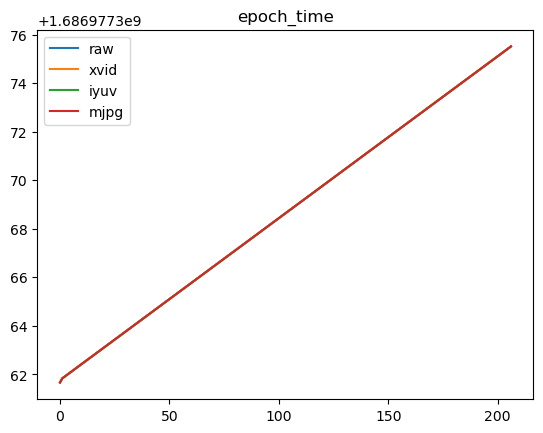

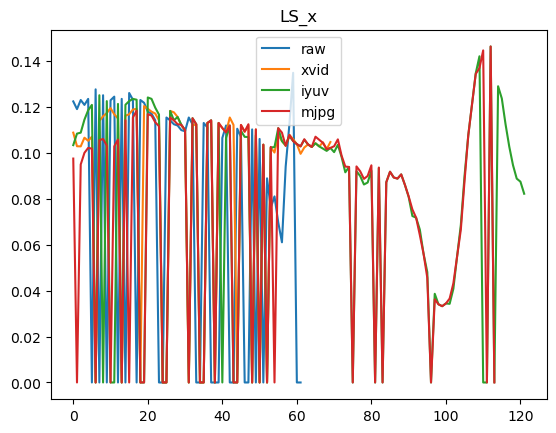

In [34]:
import matplotlib.pyplot as plt
columns=raw.columns.tolist()
dfs=[raw,xvid,iyuv,mjpg,mp4v,b48r]
dfnames=['raw','xvid','iyuv','mjpg','mp4v','b48r']
c=0
for i in columns:
    try:
        fig, ax = plt.subplots()
        for j in range(len(dfnames)):
            ax.plot(dfs[j].index, dfs[j][i])
        plt.legend(dfnames)
        plt.title(i)
        plt.show
    except:
        continue
    c+=1
    if c==2:
        break

C:\Users\arpan\AppData\Local\Temp\ipykernel_25476\2279991437.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


KeyboardInterrupt: 

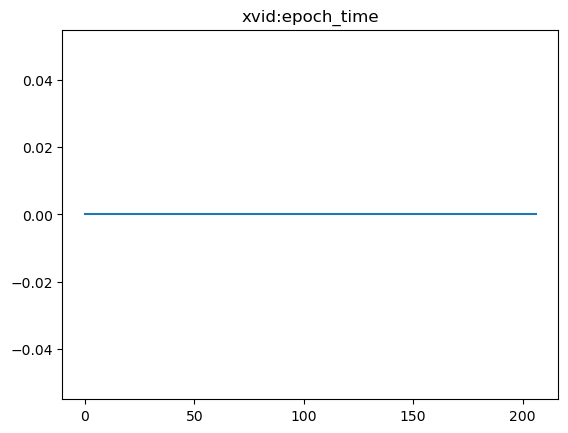

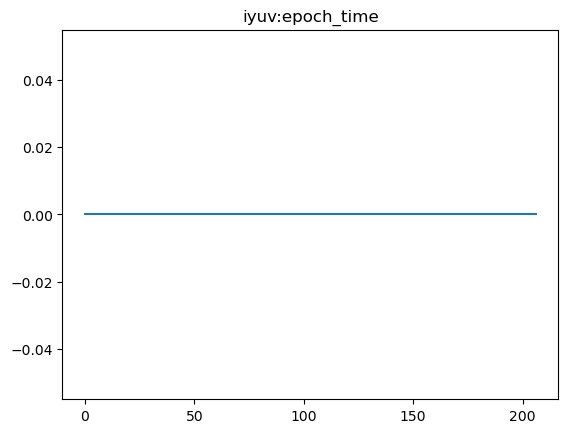

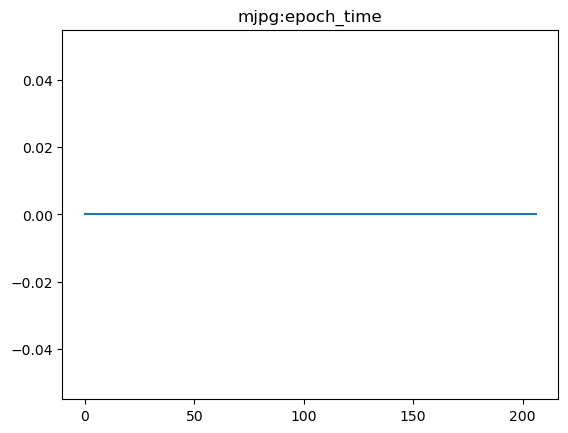

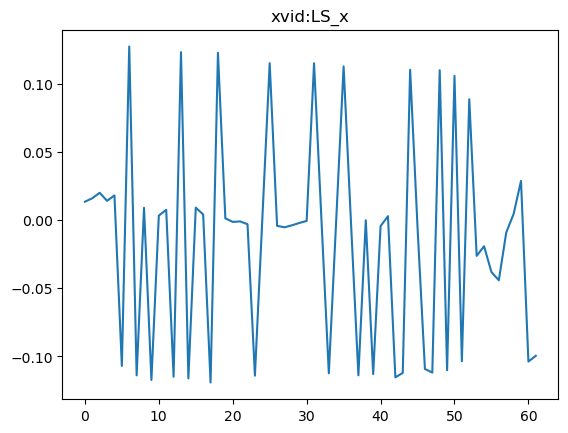

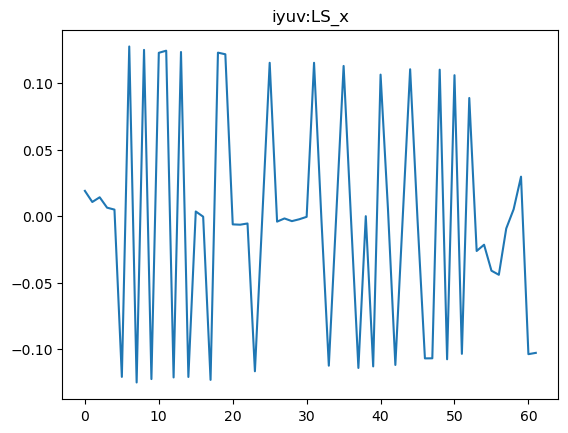

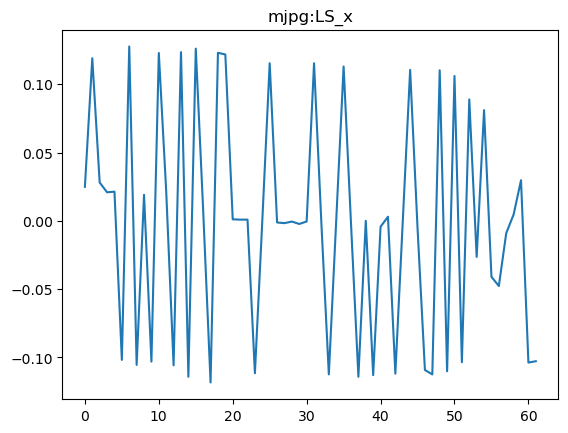

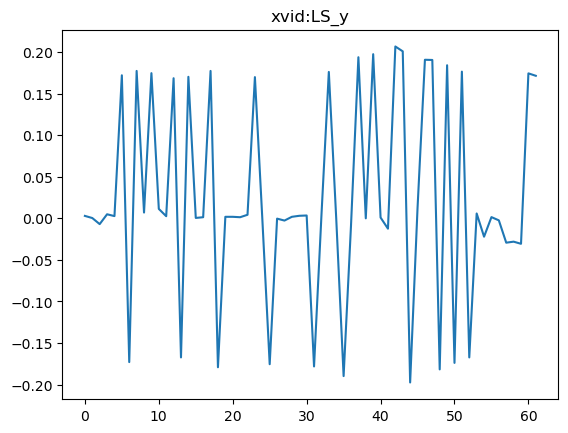

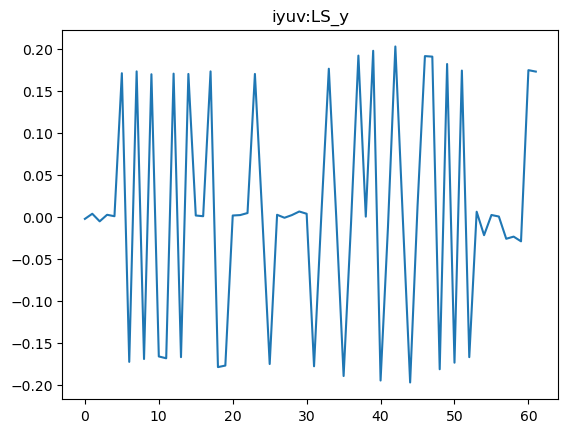

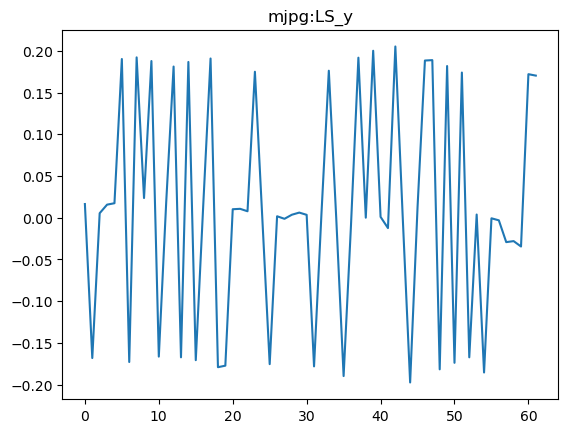

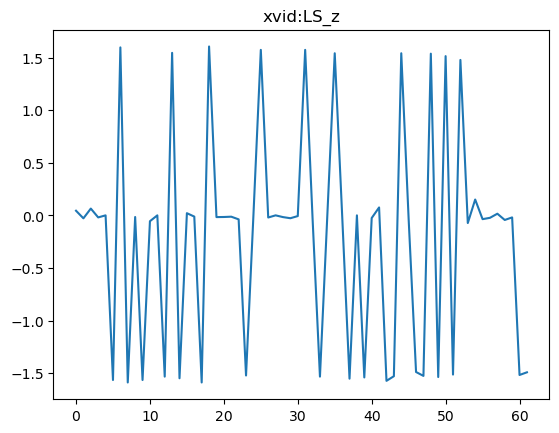

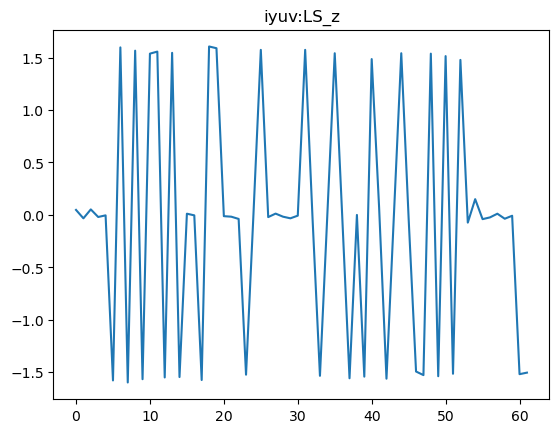

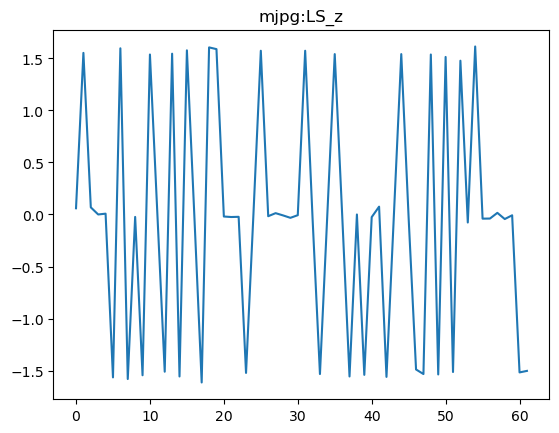

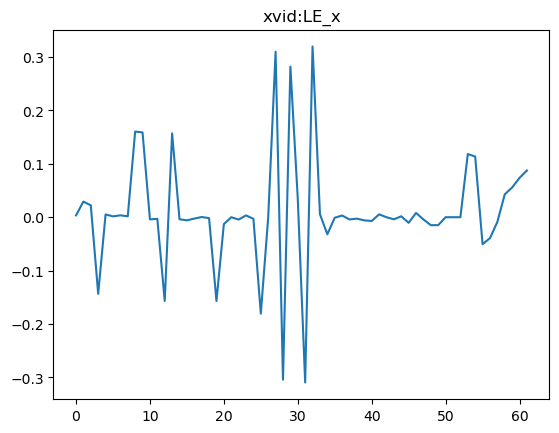

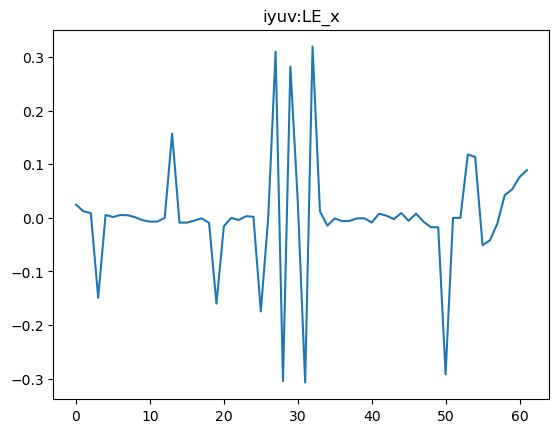

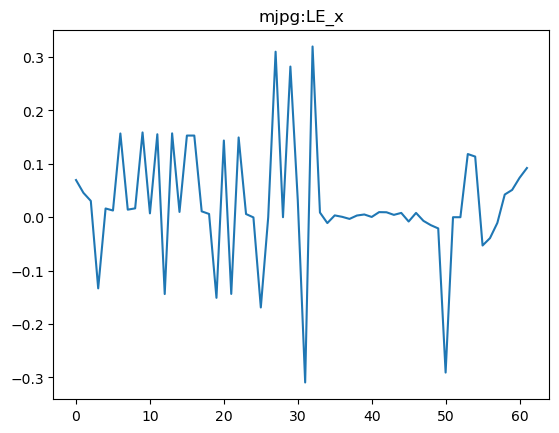

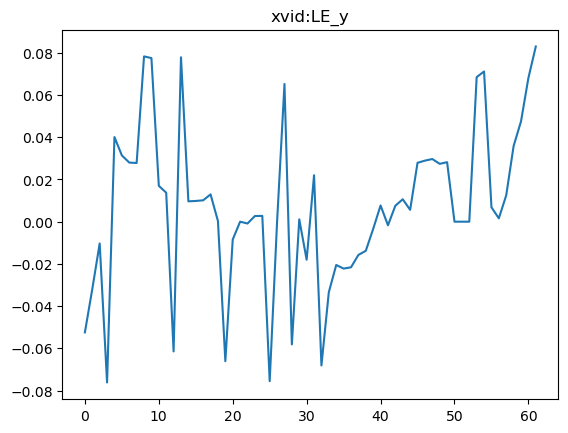

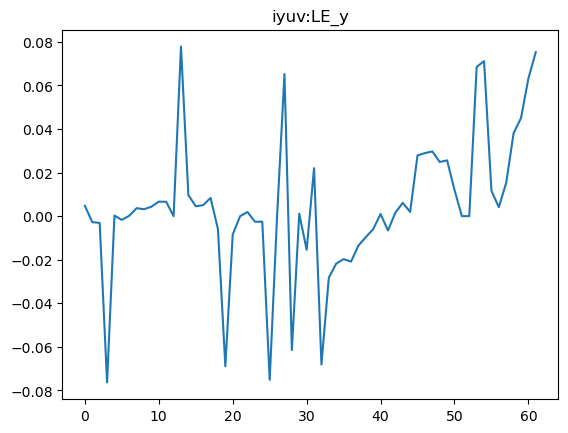

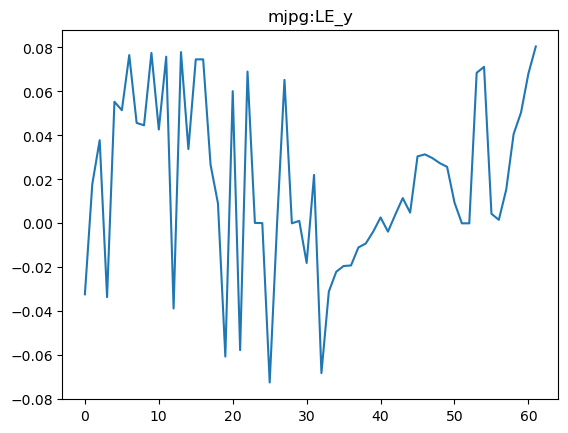

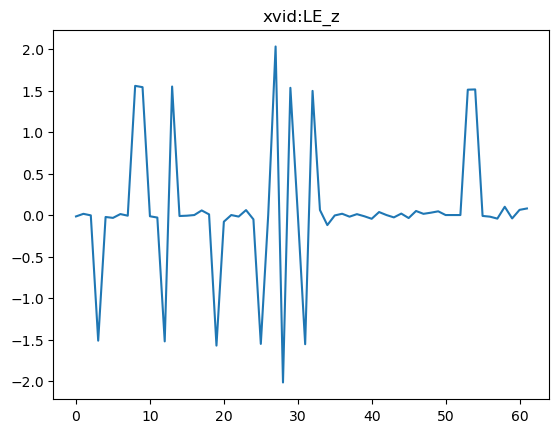

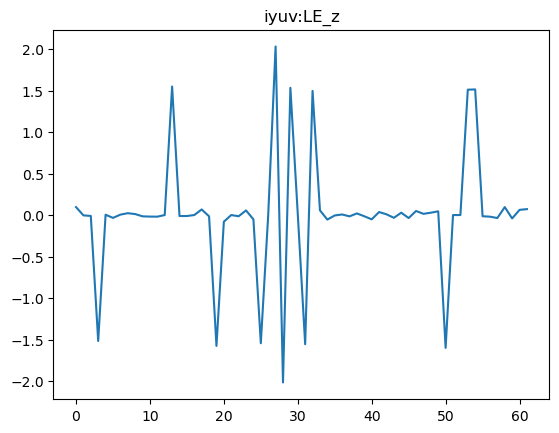

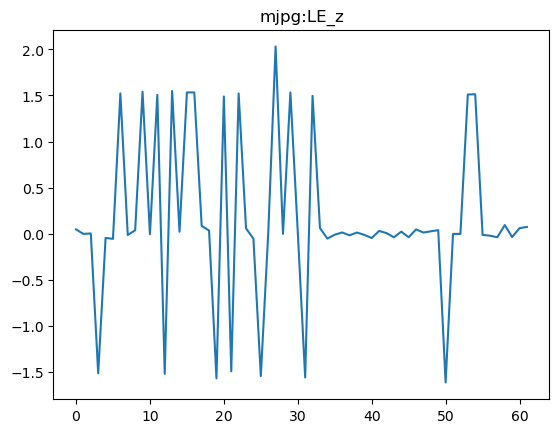

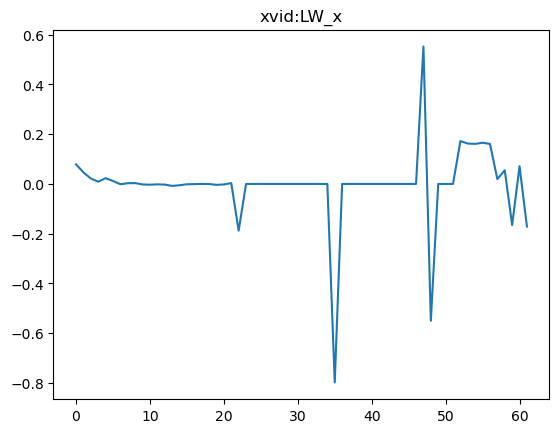

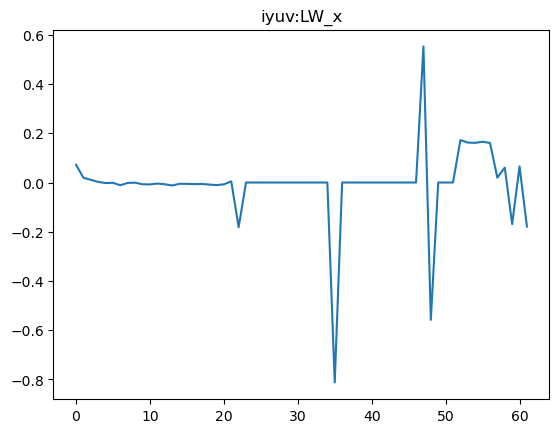

<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
columns=raw.columns.tolist()
dfs=[raw,xvid,iyuv,mjpg,mp4v,b48r]
dfnames=['raw','xvid','iyuv','mjpg','mp4v','b48r']
c=0
for i in columns:
    for j in range(1,len(dfnames)):
        try:
            fig, ax = plt.subplots()

            ax.plot(dfs[j].index, dfs[0][i]-dfs[j][i])
            # plt.legend(dfnames[1:])
            plt.title(dfnames[j]+':'+i)
            plt.show
        except:
            continue
        c+=1
        if c==20:
            break

In [ ]:
def calculate_rmse(true_df, predicted_df):
    rmse = np.sqrt(((true_df - predicted_df) ** 2).mean().mean())
    return rmse

for i,j in zip(dfs[1:],dfnames[1:]):
    print('RMSE',j,' : ',calculate_rmse(dfs[0],i))